In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
from decouple import config
import json
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from authenticate_service_account import main
from utils import *

from sklearn.model_selection import train_test_split

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

import category_encoders as ce
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor


In [2]:
def ants_preprocess(data):
    data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])

    data_with_layover = calculate_total_layover_time(data_with_od, as_ratio=True)

    data_with_layover2 = calculate_distance_difference(data_with_layover, as_ratio=True)

    data_with_redirect_ratio = redirect_ratio(data_with_layover2)

    droped_values = drop_neg_layover_time(data_with_redirect_ratio)

    return droped_values


In [3]:
data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week')
data.dropna(subset=['OriginApt', 'DestinationCty'], inplace=True)


In [4]:
economy_flights = data[data['PricePerPax']< 1500].copy()


In [5]:
processed_data = ants_preprocess(economy_flights)


In [6]:
columns = ['Stops','DurationMin', 'total_layover_time_ratio', 'OriginApt', 'DestinationApt',
            'total_distance_traveled','extra_travel_distance_ratio', 'TravelHorizonDays', 'dayofweek',
            'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA', 'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
            'TravelDistanceKm', 'PricePerPax', 'OD',
            'ItineraryRedirects', 'ODRedirects']

box_cox_columns = ['DurationMin', 'TravelDistanceKm','extra_travel_distance_ratio', 'PricePerPax']

yeo_johnson_columns = ['total_layover_time_ratio']

min_max_scaling = ['TravelHorizonDays','Stops']


In [7]:
def feature_engineering(processed_data, list_of_columns, box_cox_columns, yeo_johnson_columns, min_max_scaling):

    model_data = processed_data[list_of_columns]

    #Binary encoding origin and destination
    o_encoder = ce.BinaryEncoder(cols=['OriginApt'])
    df_binary = o_encoder.fit_transform(model_data)

    d_encoder = ce.BinaryEncoder(cols=['DestinationApt'])
    all_binary = d_encoder.fit_transform(df_binary)

    # Scaling other features

    # Box cox
    for col in box_cox_columns:
        all_binary[col], best_lambda = stats.boxcox(all_binary[col])

    # Yeo-johnson
    for col in yeo_johnson_columns:
        all_binary[col], lambda_yj = stats.yeojohnson(all_binary[col])

    #Min max scaling
    minmax_train_scaler = MinMaxScaler()
    all_binary[min_max_scaling] = minmax_train_scaler.fit_transform(all_binary[min_max_scaling])

    # Cyclical encoding
    all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    # Binary encoding Operator IATA'
    seg_0_encoder = ce.BinaryEncoder(cols=['Seg_0_OperatingCarrierIATA'])
    seg_0_binary = seg_0_encoder.fit_transform(all_binary)

    seg_1_encoder = ce.BinaryEncoder(cols=['Seg_1_OperatingCarrierIATA'])
    seg_1_binary = seg_1_encoder.fit_transform(seg_0_binary)

    seg_2_encoder = ce.BinaryEncoder(cols=['Seg_2_OperatingCarrierIATA'])
    seg_2_binary = seg_2_encoder.fit_transform(seg_1_binary)

    seg_3_encoder = ce.BinaryEncoder(cols=['Seg_3_OperatingCarrierIATA'])
    seg_3_binary = seg_3_encoder.fit_transform(seg_2_binary)

    # Creating our target
    df_with_target = scale_itin_redirects(seg_3_binary, 'ItineraryRedirects', 0, 50)

    return df_with_target


In [8]:
model_ready_data = feature_engineering(processed_data, columns,
                                       box_cox_columns, yeo_johnson_columns, min_max_scaling)


In [9]:
cols_to_drop = ['Z_Score', 'MinMax_Scaled','MinMax_Scaled', 'dayofweek',
                'Score_min_max', 'Score_Z_score', 'OD', 'ItineraryRedirects', 'ODRedirects']


In [10]:
data_with_target = model_ready_data.drop(columns=cols_to_drop).copy()


In [11]:
data_with_target['Score_Z_score_0_50'] = data_with_target['Score_Z_score_0_50'].fillna(0)


In [12]:
clean_and_processed_data = data_with_target.copy()


# Modelin'

In [13]:
X_train, X_test, y_train, y_test = train_test_split(clean_and_processed_data.drop('Score_Z_score_0_50',
                                                                                axis=1), clean_and_processed_data['Score_Z_score_0_50'], random_state=42)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(processed_data.drop('Seg_3_OperatingCarrierIATA',
                                                                                axis=1), processed_data['Seg_3_OperatingCarrierIATA'], random_state=42)


In [28]:
# k = 50
# knn_50 = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
# knn_50.fit(X_train, y_train)


KNeighborsRegressor(n_jobs=-1, n_neighbors=50)

In [29]:
# y_pred_knn = knn_50.predict(X_test)


In [ ]:
# r2_score(y_true=y_test, y_pred=y_pred_knn)


In [ ]:
# knn_50_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':y_pred_knn, 'DurationMin':X_test['DurationMin'],
#                                   "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
#                                   'Stops':X_test_all['Stops']})

# knn_50_performance_df['difference'] = knn_50_performance_df['pred_value'] - knn_50_performance_df['true_value']


In [ ]:
# sns.scatterplot(knn_50_performance_df, x='ODRedirects', y='difference', alpha=0.5, hue='ItineraryRedirects')


In [19]:
X_test.shape


(899437, 72)

In [14]:
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, Sequential


In [20]:
model = Sequential()
model.add(layers.Dense(64, input_dim=72, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)


In [22]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [23]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10
67458/67458 [==============================] - 50s 738us/step - loss: 11.4711 - mae: 0.9695 - val_loss: 1.8020 - val_mae: 0.8765
Epoch 2/10
67458/67458 [==============================] - 48s 719us/step - loss: 1.8155 - mae: 0.8677 - val_loss: 1.8034 - val_mae: 0.8829
Epoch 3/10
67458/67458 [==============================] - 50s 738us/step - loss: 1.8105 - mae: 0.8675 - val_loss: 1.8010 - val_mae: 0.8608
Epoch 4/10
67458/67458 [==============================] - 47s 703us/step - loss: 1.8103 - mae: 0.8674 - val_loss: 1.8009 - val_mae: 0.8623
Epoch 5/10
67458/67458 [==============================] - 51s 758us/step - loss: 1.8102 - mae: 0.8674 - val_loss: 1.8010 - val_mae: 0.8689
Epoch 6/10
67458/67458 [==============================] - 52s 767us/step - loss: 1.8101 - mae: 0.8674 - val_loss: 1.8009 - val_mae: 0.8612
Epoch 7/10
67458/67458 [==============================] - 51s 757us/step - loss: 1.8100 - mae: 0.8674 - val_loss: 1.8009 - val_mae: 0.8620
Epoch 8/10
67458/67458 [==

In [24]:
model.save('../models/ant_model_021223.h5')


/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


28108/28108 [==============================] - 11s 399us/step - loss: 1.7974 - mae: 0.8726
Test Loss (MSE): 1.7973785400390625
Test Error (MAE): 0.8725703358650208


In [26]:
y_pred = model.predict(X_test)


28108/28108 [==============================] - 10s 355us/step


In [39]:
y_pred.reshape(-1)


array([2.76645, 2.76645, 2.76645, ..., 2.76645, 2.76645, 2.76645],
      dtype=float32)

In [40]:
knn_50_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':y_pred.reshape(-1), 'DurationMin':X_test['DurationMin'],
                                  "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
                                  'Stops':X_test_all['Stops']})

knn_50_performance_df['difference'] = knn_50_performance_df['pred_value'] - knn_50_performance_df['true_value']


<Axes: xlabel='ODRedirects', ylabel='difference'>

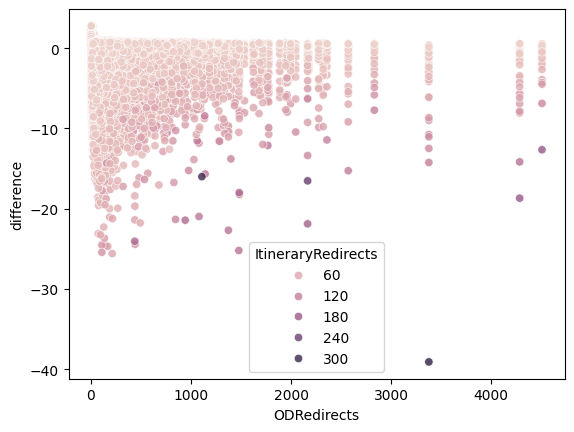

In [43]:
sns.scatterplot(knn_50_performance_df, x='ODRedirects', y='difference', alpha=0.8, hue='ItineraryRedirects')
